In [1]:
#Import Libraries 
import pandas as pd
import numpy as np
import os
import datetime
from collections import Counter
from bs4 import BeautifulSoup
import requests
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
#Create Folder
!mkdir zip
!mkdir csv
zip_path = '/content/zip/'
csv_path = '/content/csv/'

In [3]:
#Download the zipFiles from the year 2021
url = 'https://s3.amazonaws.com/capitalbikeshare-data/'
response = requests.get(url)

#Get the Filenames of the zipFiles
soup = BeautifulSoup(response.text, 'xml')
file_names = soup.find_all('Key')
zipfiles = []
for i in file_names:
  i = str(i)
  i = i.replace('<Key>', '')
  i = i.replace('</Key>', '')
  if 'zip' in i and '2021' in i:
    zipfiles.append(i)

#Download the zipFiles
download_log = []
download_log = os.listdir(zip_path)
for i in zipfiles:
  if i not in download_log:
    source = url + i
    destination = zip_path + i
    download_file = requests.get(source)
    with open(destination, 'wb') as f:
      f.write(download_file.content)
    download_log.append(i)

#Unzip the zipFiles
csv_log = []
csv_log = os.listdir(csv_path)
for i in download_log:
  if i not in csv_log:
    source = zip_path + i
    destination = csv_path
    with zipfile.ZipFile(source, 'r') as zip_ref:
      inhalt = zip_ref.namelist() 
      for j in inhalt:
        if "/" not in j and ".csv" in j:
          zip_ref.extract(j, destination)

In [4]:
#Merge the csvFiles
csv_Files = os.listdir(csv_path)
df = pd.concat([pd.read_csv(csv_path + i) for i in csv_Files ])

In [5]:
#Exploratory Data Analysis
#A quick overview of the data
print(df.shape)
print(df.describe(include='all'))

(2749881, 13)
                 ride_id rideable_type           started_at  \
count            2749881       2749881              2749881   
unique           2749881             3              2539489   
top     4B413FB6647AEEA9  classic_bike  2021-06-17 17:49:14   
freq                   1       2025847                    6   
mean                 NaN           NaN                  NaN   
std                  NaN           NaN                  NaN   
min                  NaN           NaN                  NaN   
25%                  NaN           NaN                  NaN   
50%                  NaN           NaN                  NaN   
75%                  NaN           NaN                  NaN   
max                  NaN           NaN                  NaN   

                   ended_at start_station_name  start_station_id  \
count               2749881            2553555         2553555.0   
unique              2532874                698            1247.0   
top     2021-11-04 08:21:

In [6]:
print('The data set consists of {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
print('There are {} types of bikes, with {} being the most common rental type.'.format(len(df['rideable_type'].unique()), df.groupby(['rideable_type']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][0]))
print('{} is the time when most bicycles were rented. A total of {} pieces.'.format(df.groupby(['started_at']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][0], df.groupby(['started_at']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][1]))
print('{} is the time when most of the bikes were returned. {} pieces in total.'.format(df.groupby(['ended_at']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][0], df.groupby(['ended_at']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][1]))
print('There are {} Start_Stations. {} is the Station with the most rentals ({}).'.format(len(df['start_station_name'].unique()), df.groupby(['start_station_name']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][0], df.groupby(['start_station_name']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][1]))
print('There are {} End_Stations. {} is the Station with the most returns ({}).'.format(len(df['end_station_name'].unique()), df.groupby(['end_station_name']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][0], df.groupby(['end_station_name']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][1]))
print('There are {} distinct member_casual, most bikes are borrowed from {}.'.format(len(df['member_casual'].unique()),df.groupby(['member_casual']).count().ride_id.reset_index().sort_values(by='ride_id', ascending=False).iloc[0][0]))

The data set consists of 2749881 rows and 13 columns.
There are 3 types of bikes, with classic_bike being the most common rental type.
2021-06-17 17:49:14 is the time when most bicycles were rented. A total of 6 pieces.
2021-11-04 08:21:46 is the time when most of the bikes were returned. 13 pieces in total.
There are 699 Start_Stations. Lincoln Memorial is the Station with the most rentals (29216).
There are 699 End_Stations. Lincoln Memorial is the Station with the most returns (28152).
There are 2 distinct member_casual, most bikes are borrowed from member.


In [7]:
#How many null values are in the dataset 
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    196326
start_station_id      196326
end_station_name      219259
end_station_id        219259
start_lat                  2
start_lng                  2
end_lat                 4803
end_lng                 4803
member_casual              0
dtype: int64

In [8]:
print('There are {} missing start station and {} end station. It should be possible to assign these through the Longitude and Latitude of the Station. With the exception that {} start_lat and {} end_lat are missing, which are therefore not assignable.'.format(df['start_station_name'].isnull().sum(), df['end_station_name'].isnull().sum(), df['start_lat'].isnull().sum(), df['end_lat'].isnull().sum()))
print('Since these only do make up {}% of the data, they can be dropped.'.format(round(((df['end_lat'].isnull().sum() + df['start_lat'].isnull().sum())/df['ride_id'].count()) * 100, 2)))

There are 196326 missing start station and 219259 end station. It should be possible to assign these through the Longitude and Latitude of the Station. With the exception that 2 start_lat and 4803 end_lat are missing, which are therefore not assignable.
Since these only do make up 0.17% of the data, they can be dropped.


In [9]:
#Drop rows with missing station_name and lat
df2 = df[~((df['start_station_name'].isnull()) & (df['start_lat'].isnull()))]
df2 = df[~((df['end_station_name'].isnull()) & (df['end_lat'].isnull()))]

In [10]:
#How many null values are in the dataset after dropping the null values from end_lat and end_lng
df2.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    196326
start_station_id      196326
end_station_name      214458
end_station_id        214458
start_lat                  2
start_lng                  2
end_lat                    2
end_lng                    2
member_casual              0
dtype: int64

In [11]:
#Combine start and end_station and groupby the station_name and staion_id by the mean of the lat and lng
df_start = df[['start_station_name', 'start_station_id', 'start_lat', 'start_lng']]
df_start = df_start.rename(columns={"start_station_name": "station_name", "start_station_id": "station_id", "start_lat": "lat", "start_lng": "lng"})
df_end = df[['end_station_name', 'end_station_id', 'end_lat', 'end_lng']]
df_end = df_end.rename(columns={"end_station_name": "station_name", "end_station_id": "station_id", "end_lat": "lat", "end_lng": "lng"})
df_station = pd.concat([df_start, df_end], ignore_index=True)
df_station = df_station[~df_station['station_name'].isnull()]
df_station = df_station.drop_duplicates()
df_station = df_station.groupby(['station_name', 'station_id']).mean()
df_station = df_station.reset_index()

In [12]:
#Get the missing start_ and end_station from the corresponding lat and lng
def get_start_station(x, y=df_station):
  if pd.isnull(x['start_station_name']):
    y = y.iloc[(y['lat']-x['start_lat']).abs().argsort()[:10]]
    y = y.iloc[(y['lng']-x['start_lng']).abs().argsort()[:1]]
    return pd.Series([y['station_id'].tolist()[0] , y['station_name'].tolist()[0]])
  else: 
    return pd.Series([x['start_station_id'], x['start_station_name']])

def get_end_station(x, y=df_station):
  if pd.isnull(x['end_station_name']):
    y = y.iloc[(y['lat']-x['end_lat']).abs().argsort()[:10]]
    y = y.iloc[(y['lng']-x['end_lng']).abs().argsort()[:1]]
    return pd.Series([y['station_id'].tolist()[0] , y['station_name'].tolist()[0]])
  else: 
    return pd.Series([x['end_station_id'], x['end_station_name']])

df2[['start_station_id', 'start_station_name']] = df2.apply(get_start_station, axis=1)
df2[['end_station_id', 'end_station_name']] = df2.apply(get_end_station, axis=1)

In [13]:
#Align the lat and lng fields
def get_lat_lng(x, y=df_station):
  s_id = x['start_station_id']
  e_id = x['end_station_id']
  return pd.Series([y['lat'][y['station_id']==s_id].tolist()[0], y['lng'][y['station_id']==s_id].tolist()[0], y['lat'][y['station_id']==e_id].tolist()[0], y['lng'][y['station_id']==e_id].tolist()[0]])

df2[['start_lat', 'start_lng', 'end_lat', 'end_lng']] = df2.apply(get_lat_lng, axis=1)

In [14]:
#Get the data types and change them accordingly
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2745080 entries, 0 to 77504
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 293.2+ MB


In [26]:
#Drop all rows with null values
df2 = df2.dropna()

In [27]:
#Changing started_at and ended_at to timestamp and start_station_id and end_station_id to Integer
df2 = df2.astype({'start_station_id': 'int32', 'end_station_id': 'int32'})
df2[['started_at', 'ended_at']] = df2[['started_at', 'ended_at']].apply(pd.to_datetime, errors='coerce')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2744826 entries, 0 to 77504
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    int32         
 6   end_station_name    object        
 7   end_station_id      int32         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), int32(2), object(5)
memory usage: 272.2+ MB


In [28]:
#Add a Day, Weekday, Hour, Month, Day of the Year and Duration column to the dataframe
df2['start_day'] = df2['started_at'].apply(lambda x: x.day)
df2['start_weekday'] = df2['started_at'].apply(lambda x: x.weekday())
df2['start_hour'] = df2['started_at'].apply(lambda x: x.hour)
df2['start_month'] = df2['started_at'].apply(lambda x: x.month)
df2['start_doy'] = df2['started_at'].apply(lambda x: x.strftime('%j')).astype('int32')
df2['end_day'] = df2['ended_at'].apply(lambda x: x.day)
df2['end_weekday'] = df2['ended_at'].apply(lambda x: x.weekday())
df2['end_hour'] = df2['ended_at'].apply(lambda x: x.hour)
df2['end_month'] = df2['ended_at'].apply(lambda x: x.month)
df2['end_doy'] = df2['ended_at'].apply(lambda x: x.strftime('%j')).astype('int32')
df2['duration'] = df2.apply(lambda x: (x['ended_at'] - x['started_at']) / np.timedelta64(1, 's'), axis=1)

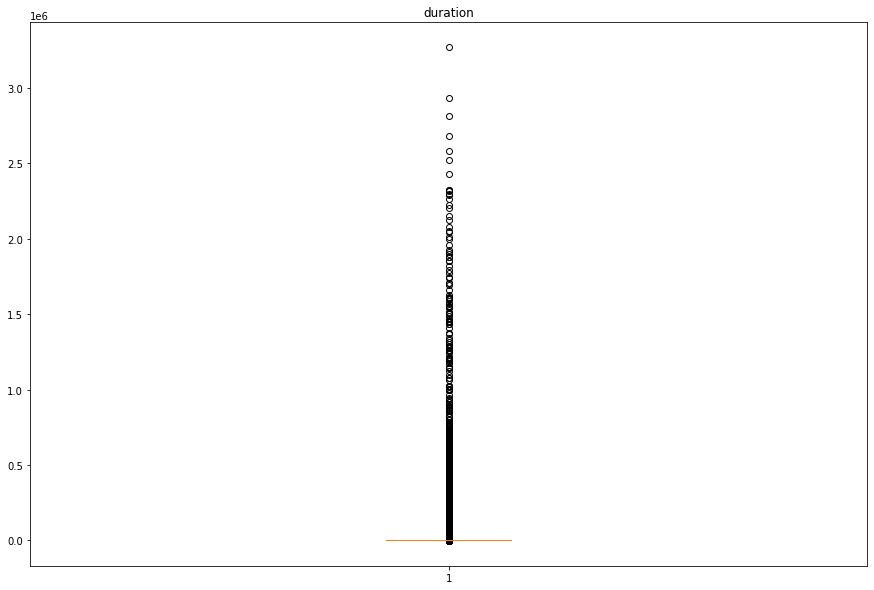

In [29]:
#Plot a Boxplot of the duration
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(df2['duration'])
ax.set_title("duration")
plt.show()

In [30]:
print("The mininum rental lenght is: {} minutes".format((df2['duration'].min()/60).astype('int32')))
print("{} rentals lengths are negative".format(df2['duration'][df2['duration'] < 0].count()))
print("The mininum rental lenght greater than 0 is: {} second(s)".format(df2['duration'][df2['duration'] > 0].min().astype('int32')))
print("{} rentals lengths are less than a minute".format(df2['duration'][df2['duration'] < 60].count()))
print("The maximum rental lenght is: {} minutes or {} days".format((df2['duration'].max()/60).astype('int32'), (df2['duration'].max()/60/60).astype('int32')))
print("{} rentals lengths are longer than 7 days".format(df2['duration'][df2['duration'] > 60*24*7].count()))
print("The mean rental length is : {} minutes".format(round((df2['duration'].mean()/60),2)))
print("the median rental length is: {} minutes".format((df2['duration'].median()/60).astype('int32')))

The mininum rental lenght is: -88 minutes
315 rentals lengths are negative
The mininum rental lenght greater than 0 is: 1 second(s)
37812 rentals lengths are less than a minute
The maximum rental lenght is: 54540 minutes or 909 days
17747 rentals lengths are longer than 7 days
The mean rental length is : 23.23 minutes
the median rental length is: 12 minutes


In [31]:
#Remove rentals which are lower than 1 minute and higher than 7 days
df2.drop(df2[(df2.duration < 60) | (df2.duration > 60*24*7)].index, inplace=True)

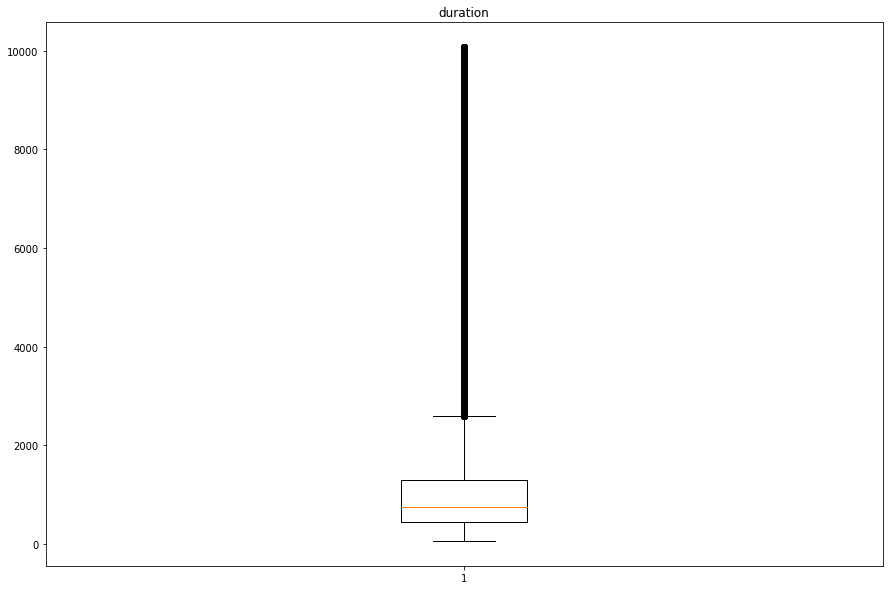

In [32]:
#Plot a Boxplot of the duration
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(df2['duration'])
ax.set_title("duration")
plt.show()

In [33]:
print("The mininum rental lenght is: {} minutes".format((df2['duration'].min()/60).astype('int32')))
print("{} rentals lengths are negative".format(df2['duration'][df2['duration'] < 0].count()))
print("The mininum rental lenght greater than 0 is: {} second(s)".format(df2['duration'][df2['duration'] > 0].min().astype('int32')))
print("{} rentals lengths are less than a minute".format(df2['duration'][df2['duration'] < 60].count()))
print("The maximum rental lenght is: {} minutes or {} days".format((df2['duration'].max()/60).astype('int32'), (df2['duration'].max()/60/60).astype('int32')))
print("{} rentals lengths are longer than 7 days".format(df2['duration'][df2['duration'] > 60*24*7].count()))
print("The mean rental length is : {} minutes".format(round((df2['duration'].mean()/60),2)))
print("the median rental length is: {} minutes".format((df2['duration'].median()/60).astype('int32')))

The mininum rental lenght is: 1 minutes
0 rentals lengths are negative
The mininum rental lenght greater than 0 is: 60 second(s)
0 rentals lengths are less than a minute
The maximum rental lenght is: 168 minutes or 2 days
0 rentals lengths are longer than 7 days
The mean rental length is : 18.57 minutes
the median rental length is: 12 minutes


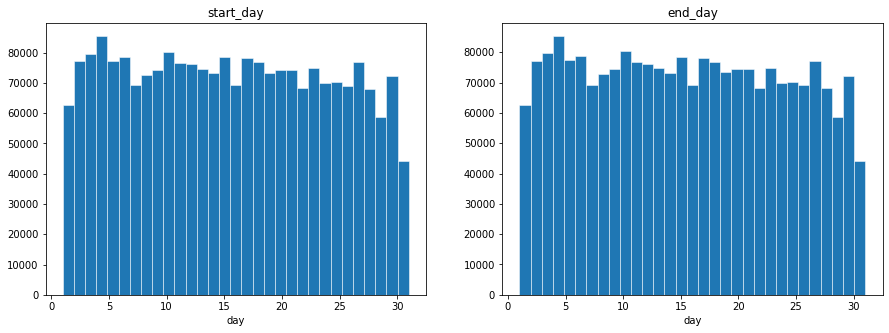

In [34]:
#Plot a histogramm of the start_ and end_day
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(df2['start_day'], bins=31, linewidth=0.5, edgecolor="white")
ax[0].set_title("start_day")
ax[0].set_xlabel("day")
ax[1].hist(df2['end_day'], bins=31, linewidth=0.5, edgecolor="white")
ax[1].set_title("end_day")
ax[1].set_xlabel("day")
plt.show()

Rentals are about the same over a month with a small peak at the beginning of the month.

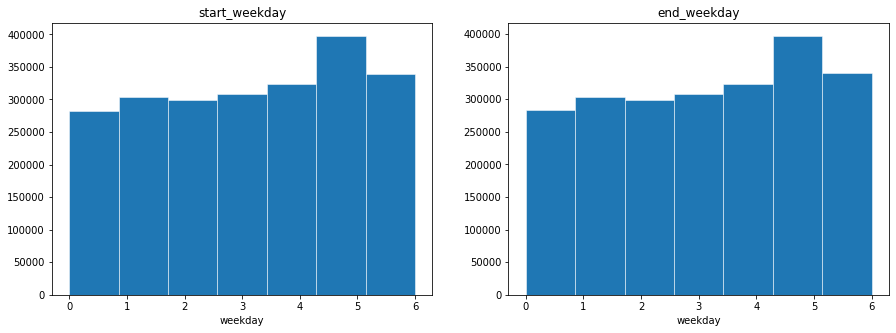

In [35]:
#Plot a histogramm of the start_ and end_weekday
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(df2['start_weekday'], bins=7, linewidth=0.5, edgecolor="white")
ax[0].set_title("start_weekday")
ax[0].set_xlabel("weekday")
ax[1].hist(df2['end_weekday'], bins=7, linewidth=0.5, edgecolor="white")
ax[1].set_title("end_weekday")
ax[1].set_xlabel("weekday")
plt.show()

In [36]:
df2['start_weekday'].groupby(df2['start_weekday']).count().sort_values(ascending=False)

start_weekday
5    397561
6    338793
4    324113
3    309026
1    303750
2    299616
0    282897
Name: start_weekday, dtype: int64

In [37]:
df2['end_weekday'].groupby(df2['end_weekday']).count().sort_values(ascending=False)

end_weekday
5    397201
6    340548
4    322788
3    308706
1    303521
2    299572
0    283420
Name: end_weekday, dtype: int64

Demand is highest on Saturday, followed by Sunday. Demand is lowest on Monday (Monday = 0)

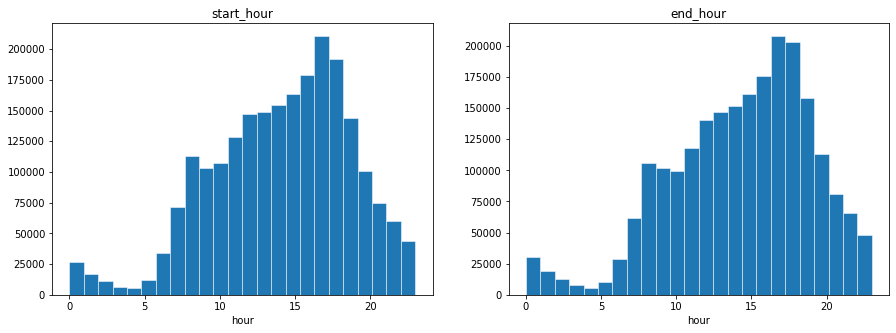

In [38]:
#Plot a histogramm of the start_ and end_hour
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(df2['start_hour'], bins=24, linewidth=0.5, edgecolor="white")
ax[0].set_title("start_hour")
ax[0].set_xlabel("hour")
ax[1].hist(df2['end_hour'], bins=24, linewidth=0.5, edgecolor="white")
ax[1].set_title("end_hour")
ax[1].set_xlabel("hour")
plt.show()

In [39]:
df2['start_hour'].groupby(df2['start_hour']).count().sort_values(ascending=False)

start_hour
17    210731
18    191639
16    178739
15    163458
14    154901
13    148741
12    146975
19    143821
11    128139
8     113040
10    107648
9     103004
20    100804
21     74976
7      71759
22     60452
23     43946
6      34190
0      26386
1      16882
5      12401
2      11280
3       6226
4       5618
Name: start_hour, dtype: int64

In [40]:
df2['end_hour'].groupby(df2['end_hour']).count().sort_values(ascending=False)

end_hour
17    207997
18    202846
16    175735
15    161244
19    157977
14    151759
13    147012
12    140405
11    118005
20    113361
8     105788
9     101807
10     99684
21     80841
22     66027
7      61900
23     48132
0      30314
6      29054
1      19383
2      12794
5      10432
3       7620
4       5639
Name: end_hour, dtype: int64

At 8 a.m. there is the first peak, presumably people who cycle to work. It reaches a plateau between 12-2pm and then rises until 5pm. Presumably people who cycle home from work. Demand then decreases and falls rapidly into night mode from 7 p.m.

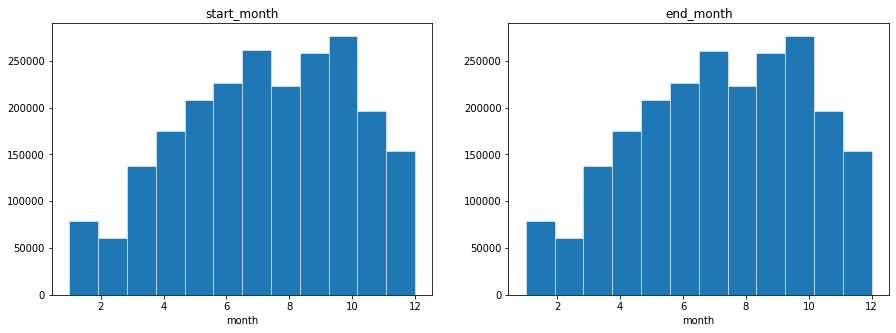

In [41]:
#Plot a histogramm of the start_ and end_month
b = df2['start_month'].max()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(df2['start_month'], bins=b, linewidth=0.5, edgecolor="white")
ax[0].set_title("start_month")
ax[0].set_xlabel("month")
ax[1].hist(df2['end_month'], bins=b, linewidth=0.5, edgecolor="white")
ax[1].set_title("end_month")
ax[1].set_xlabel("month")
plt.show()

Demand for rental bikes increases from winter to summer with a peak in October and a "dip" in demand in August. The dip could have something to do with a calming of the Covid infections and thus a more carefree population.

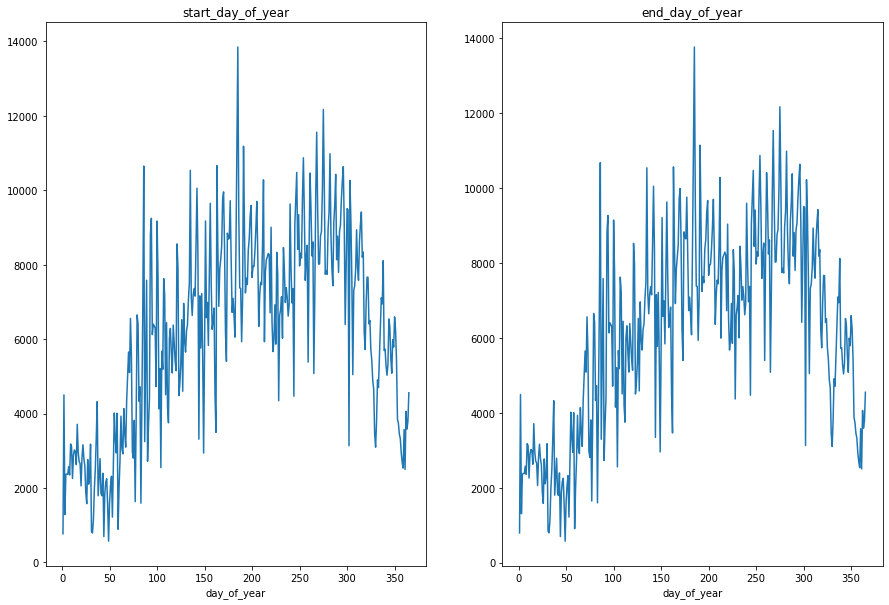

In [42]:
#Plot Trendlines
fig, ax = plt.subplots(1,2, figsize=(15,10))

ax[0].plot(df2['start_doy'].value_counts().sort_index())
ax[0].set_title("start_day_of_year")
ax[0].set_xlabel("day_of_year")
ax[1].plot(df2['end_doy'].value_counts().sort_index())
ax[1].set_title("end_day_of_year")
ax[1].set_xlabel("day_of_year")

plt.show()

The course per day in the year confirms the observation that the course per month has already provided

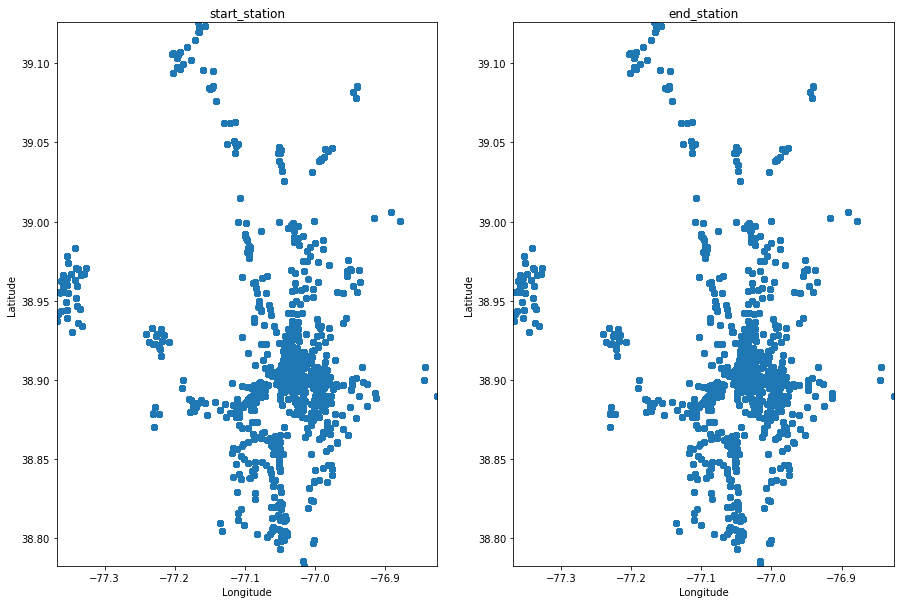

In [43]:
#Plot Scatterplots betwenn lat and lng
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].scatter(df2['start_lng'], df2['start_lat'])
ax[0].set(xlim=(df2['start_lng'][df2['start_lng']<0].min(), df2['start_lng'][df2['start_lng']<0].max()), ylim=(df2['start_lat'][df2['start_lat']>0].min(), df2['start_lat'][df2['start_lat']>0].max()))
ax[0].set_title("start_station")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

ax[1].scatter(df2['end_lng'], df2['end_lat'])
ax[1].set(xlim=(df2['end_lng'][df2['end_lng']<0].min(), df2['end_lng'][df2['end_lng']<0].max()), ylim=(df2['end_lat'][df2['end_lat']>0].min(), df2['end_lat'][df2['end_lat']>0].max()))
ax[1].set_title("end_station")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

plt.show()

In [50]:
print("{} members used the service and {} casual user used it".format(df2['ride_id'].groupby(df2['member_casual']).count()['member'], df2['ride_id'].groupby(df2['member_casual']).count()['casual']))

1343305 members used the service and 912451 casual user used it


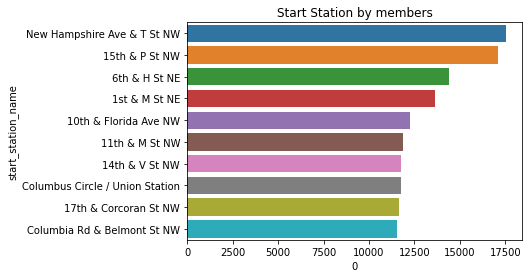

In [102]:
#Plot Top 10 Start- and Endstation by userstatus
member_start = pd.DataFrame(df2['start_station_name'][df2['member_casual'] == 'member'])
member_start = pd.DataFrame(member_start.groupby(member_start['start_station_name']).size()).sort_values(by=0, ascending=False).head(10)
member_start = member_start.reset_index()
sns.barplot(y='start_station_name', x=0, data = member_start).set(title='Start Station by members')

plt.show()

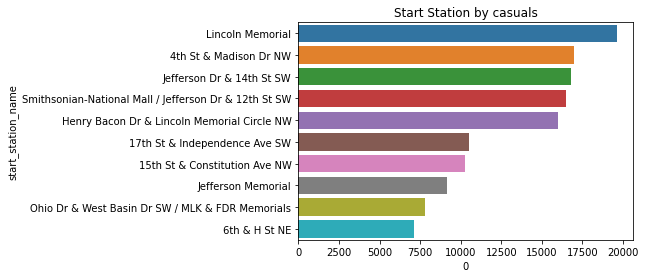

In [103]:
casual_start = pd.DataFrame(df2['start_station_name'][df2['member_casual'] == 'casual'])
casual_start = pd.DataFrame(casual_start.groupby(casual_start['start_station_name']).size()).sort_values(by=0, ascending=False).head(10)
casual_start = casual_start.reset_index()
sns.barplot(y='start_station_name', x=0, data = casual_start).set(title='Start Station by casuals')

plt.show()

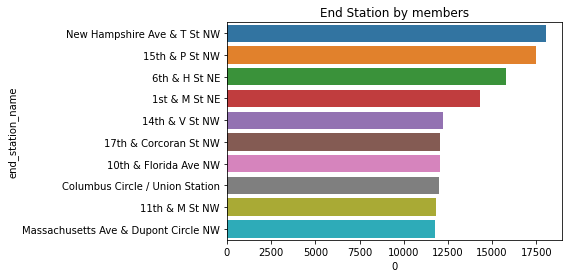

In [104]:
member_end = pd.DataFrame(df2['end_station_name'][df2['member_casual'] == 'member'])
member_end = pd.DataFrame(member_end.groupby(member_end['end_station_name']).size()).sort_values(by=0, ascending=False).head(10)
member_end = member_end.reset_index()
sns.barplot(y='end_station_name', x=0, data = member_end).set(title='End Station by members')

plt.show()

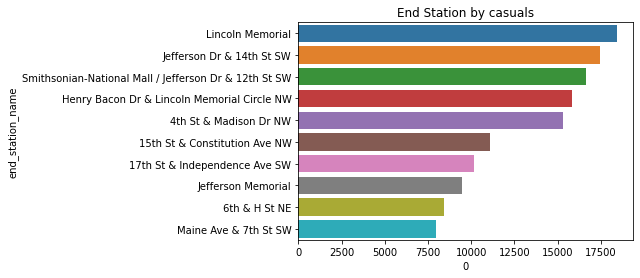

In [105]:
casual_end = pd.DataFrame(df2['end_station_name'][df2['member_casual'] == 'casual'])
casual_end = pd.DataFrame(casual_end.groupby(casual_end['end_station_name']).size()).sort_values(by=0, ascending=False).head(10)
casual_end = casual_end.reset_index()
sns.barplot(y='end_station_name', x=0, data = casual_end).set(title='End Station by casuals')

plt.show()

The start and end station of the different users differ. Casual are probably more tourists and head for tourist destinations, whereas members use the rental bikes to commute to work.

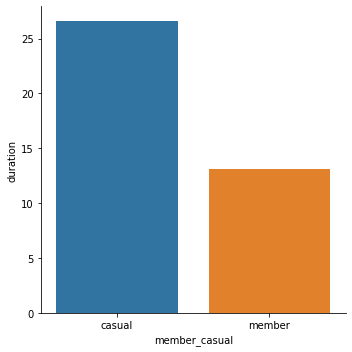

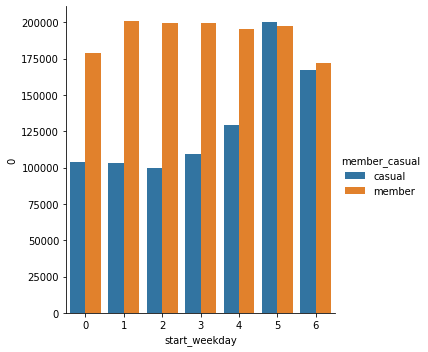

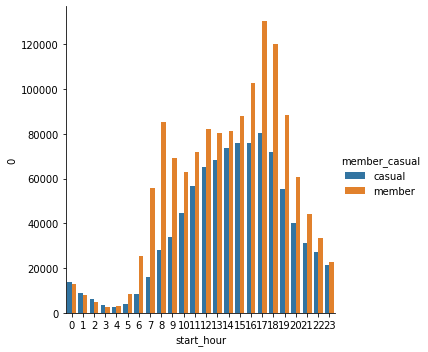

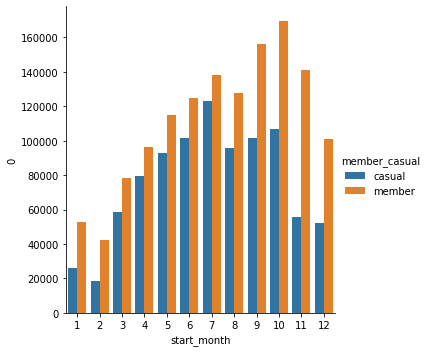

In [47]:
#Plot Barplots which show the difference between member and casual by duration, start_weekday, start_hour, start_month and start_doy
dur = pd.DataFrame(df2.groupby(df2['member_casual'])['duration'].mean()/60).reset_index()
sns.catplot(x='member_casual', y='duration', data = dur, kind='bar')

week = df2.groupby(['member_casual', 'start_weekday']).size().reset_index()
sns.catplot(x = "start_weekday", y = 0, hue = "member_casual", data = week, kind = "bar")

hour = df2.groupby(['member_casual', 'start_hour']).size().reset_index()
sns.catplot(x = "start_hour", y = 0, hue = "member_casual", data = hour, kind = "bar")

month = df2.groupby(['member_casual', 'start_month']).size().reset_index()
sns.catplot(x = "start_month", y = 0, hue = "member_casual", data = month, kind = "bar")

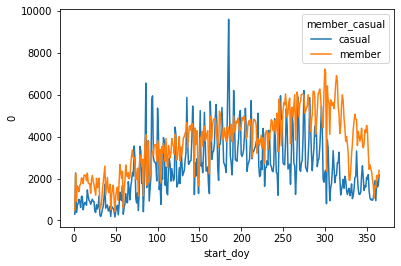

In [48]:
doy = df2.groupby(['member_casual', 'start_doy']).size().reset_index()
sns.lineplot(x = "start_doy", y = 0, hue = "member_casual", data = doy)

The average rental duration is higher for casual users than for members. From this it can be concluded that they often go on longer sightseeing tours or they use it as a leisure activity.

Member users rent more bikes on weekdays and Sundays than casual users, who in turn rent more on Saturdays.

Members mainly rent bikes in the mornings between 7 a.m. and 9 a.m. and between 4 p.m. and 6 p.m. This suggests an active use for commuting. Casual users peak around 5pm.

Casual users use the service more and more during the warm season. In winter, use is reduced. Member users, on the other hand, have seen an increase in usage and only in the last 1.5 months has there been a drop. This is probably related to the Covid situation and then to the colder weather.